In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Fast Segment Anything Model (FastSAM)

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)


HOME: /content


## Install FastSAM, SAM, and other dependencies

In [ ]:
%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget


/content
Cloning into 'FastSAM'...
remote: Enumerating objects: 1329, done.
remote: Counting objects: 100% (494/494), done.
remote: Compressing objects: 100% (155/155), done.
remote: Total 1329 (delta 377), reused 399 (delta 338), pack-reused 835
Receiving objects: 100% (1329/1329), 72.57 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (530/530), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download FastSAM and SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh {HOME}/weights


total 2.6G
-rw-r--r-- 1 root root 139M Jun 20  2023 FastSAM.pt
-rw-r--r-- 1 root root 2.4G Apr  4  2023 sam_vit_h_4b8939.pth


In [ ]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"


## provide example data url

**NONE:** Let's download few example images. We can use your images or videos as well.

In [ ]:
!mkdir -p {HOME}/data

!wget -P {HOME}/data -q https://drvidyahattangadi.com/wp-content/uploads/2018/03/indianroadtrip1.jpg
!wget -P {HOME}/data -q https://i.dawn.com/large/2019/07/5d210446cae2b.jpg
!wget -P {HOME}/data -q http://www.pavemanpro.com/images/uploads/raveling.jpg

!ls -lh {HOME}/data


total 344K
-rw-r--r-- 1 root root  52K Jul  6  2019 5d210446cae2b.jpg
-rw-r--r-- 1 root root 155K Sep 23  2022 indianroadtrip1.jpg
-rw-r--r-- 1 root root 134K Jan 11  2018 raveling.jpg


## Imports

**NOTE:** `FastSAM` code is not distributed via `pip` not it is packaged. Make sure to run code below from `{HOME}/FastSAM` directory. ⚠️

In [ ]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


/content/FastSAM


## Load FastSAM

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE = {DEVICE}")
fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)


DEVICE = cpu


## FastSAM inference

* `retina_masks=True` determines whether the model uses retina masks for generating segmentation masks.
* `imgsz=1024` sets the input image size to 1024x1024 pixels for processing by the model.
* `conf=0.4` sets the minimum confidence threshold for object detection.
* `iou=0.9` sets the minimum intersection over union threshold for non-maximum suppression to filter out duplicate detections.

In [ ]:
#IMAGE_PATH = f"{HOME}/data/raveling.jpg"
#os.makedirs(f"{HOME}/output", exist_ok=True)

In [ ]:
import os

# Define the paths and parameters
IMAGE_PATH = "/content/drive/MyDrive/Fast SAM test Images/frame_0495.png"
output_dir = "/content/output"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)


In [ ]:
# Run the FastSAM model
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9
)

# Process the results
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()

# Define the output path for the plot
output_path = os.path.join(output_dir, "output_plot.jpg")  # Modify the filename as needed

# Plot the results and save directly to the desired output directory
prompt_process.plot(annotations=masks, output_path=output_path)



image 1/1 /content/drive/MyDrive/Fast SAM test Images/frame_0495.png: 576x1024 60 objects, 8944.2ms
Speed: 18.4ms preprocess, 8944.2ms inference, 1179.9ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.everything_prompt` returns `torch.Tensor` when DEVICE = 'cuda:0'. `prompt_process.everything_prompt` returns `numpy.ndarray` when DEVICE = 'cpu'.

In [ ]:
# Convert masks to boolean (True/False)
def masks_to_bool(masks):
    if type(masks) == np.ndarray:
        return masks.astype(bool)
    return masks.cpu().numpy().astype(bool)


In [ ]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
    return mask_annotator.annotate(scene=image.copy(), detections=detections)


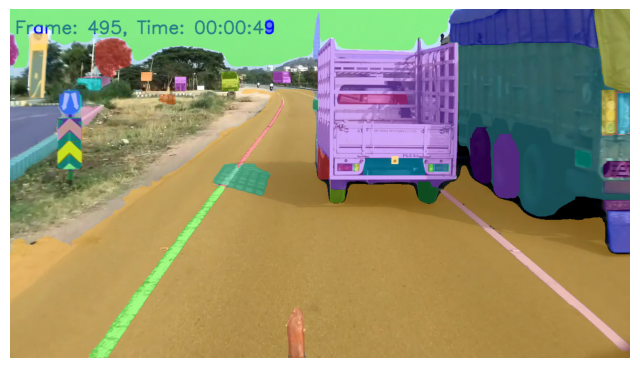

In [ ]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))


**NOTE:** The quality of the generated masks is quite poor. Let's see if we can improve it by manipulating the parameters.

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()



image 1/1 /content/drive/MyDrive/Fast SAM test Images/frame_0495.png: 576x1024 41 objects, 8851.9ms
Speed: 12.2ms preprocess, 8851.9ms inference, 750.1ms postprocess per image at shape (1, 3, 1024, 1024)


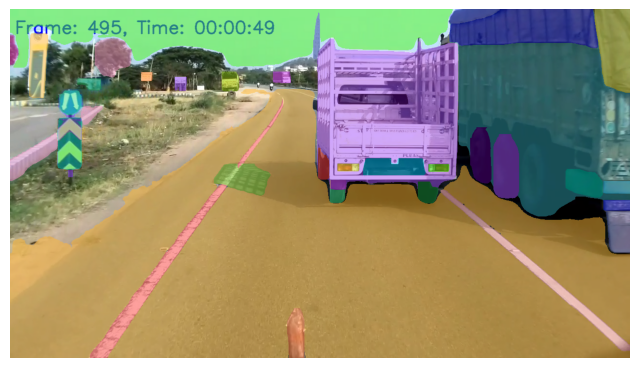

In [ ]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))


## FastSAM box prompt inference
*   Draw Box
*   Provide x, y, width, height, label





### Draw Box

In [ ]:
# helper function that loads an image before adding it to the widget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded


**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes


[{'x': 338, 'y': 460, 'width': 673, 'height': 126, 'label': ''}]

### Generate mask `manual x, y, width, height, label` with FastSAM

In [ ]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 338, 'y': 460, 'width': 673, 'height': 126, 'label': 'road'}

box = widget.bboxes[0] if widget.bboxes else default_box
box = [
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bbox=box)



image 1/1 /content/drive/MyDrive/Fast SAM test Images/frame_0495.png: 576x1024 41 objects, 13869.3ms
Speed: 8.8ms preprocess, 13869.3ms inference, 740.5ms postprocess per image at shape (1, 3, 1024, 1024)


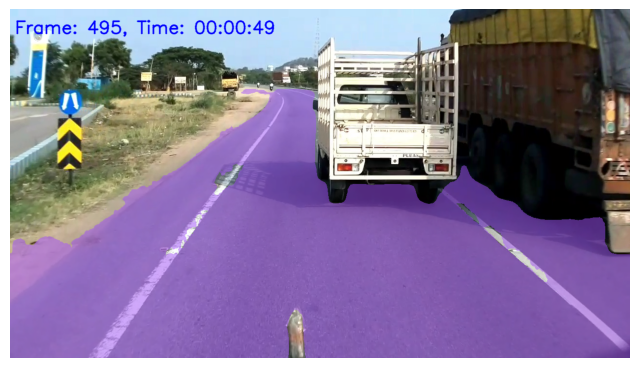

In [ ]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))
# Calculate pixel count of segmented/annotated area
masked_pixels = np.sum(masks)


Pixel count of masked area: 441790
Mask shape: (1, 720, 1280)


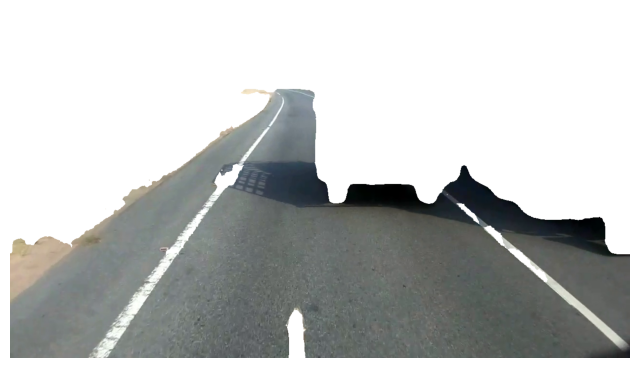

In [ ]:
# Display pixel count
print(f"Pixel count of masked area: {masked_pixels}")

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Check the shape of the masks array
print(f"Mask shape: {masks.shape}")

# Extract the masked part of the image
original_image = cv2.imread(IMAGE_PATH)
height, width = original_image.shape[:2]
masked_image = np.zeros_like(original_image)

# Ensure the mask is in the correct shape
if len(masks.shape) == 3 and masks.shape[0] == 1:
    masks = masks[0]  # Remove the first dimension if it's a singleton

# Resize the mask to match the original image dimensions if necessary
if masks.shape[0] != height or masks.shape[1] != width:
    masks_resized = cv2.resize(masks.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST).astype(bool)
else:
    masks_resized = masks

# Apply the mask to the original image
for i in range(3):  # Apply mask to each channel (R, G, B)
    masked_image[:, :, i] = np.where(masks_resized, original_image[:, :, i], 255)

# Plot the masked image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
import pandas as pd
from datetime import timedelta

# Define the paths
input_video_path = "/content/drive/MyDrive/Projects/NH-44, Telangana/HYD Survey Videos/HYD Road and Frames /HYD LHS road videos/Start to End Hyderabad Part 1 (5 sec).mp4"
output_video_path = "/content/output/video.mp4"
csv_output_path = "/content/output/data.csv"

# Open the input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Define the output video writer
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Initialize a list to store the data
data = []

# Default box prompt
default_box = {'x': 293, 'y': 192, 'width': 566, 'height': 511, 'label': 'road'}
box = [default_box['x'], default_box['y'], default_box['x'] + default_box['width'], default_box['y'] + default_box['height']]

frame_number = 0

def masks_to_bool(masks):
    if isinstance(masks, np.ndarray):
        return masks.astype(bool)
    elif isinstance(masks, list):
        return [mask.astype(bool) for mask in masks]
    raise TypeError("Unsupported type for masks. Expected np.ndarray or list of np.ndarrays.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    timestamp = str(timedelta(seconds=frame_number / fps))

    # Print the current frame number being processed
    print(f"Processing frame {frame_number}/{frame_count}")

    # Run the FastSAM model
    results = fast_sam(
        source=frame,
        device=DEVICE,
        retina_masks=True,
        imgsz=1024,
        conf=0.5,
        iou=0.6
    )

    # Process the results
    prompt_process = FastSAMPrompt(frame, results, device=DEVICE)
    masks = prompt_process.box_prompt(bbox=box)

    # Convert masks to boolean
    masks = masks_to_bool(masks)

    # Calculate pixel count of segmented/annotated area
    masked_pixels = np.sum(masks)

    # Create a mask with white background
    masked_image = np.zeros_like(frame, dtype=np.uint8)
    masked_image.fill(255)
    for c in range(frame.shape[2]):
        masked_image[:, :, c] = np.where(masks, frame[:, :, c], 255)

    # Annotate the frame with pixel count
    cv2.putText(masked_image, f"Pixel count: {masked_pixels}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Append data to list
    data.append({"Frame": frame_number, "Timestamp": timestamp, "Pixel_Count": masked_pixels})

    # Save the annotated frame to the output video
    out.write(masked_image)

# Release resources
cap.release()
out.release()

# Convert list to DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(csv_output_path, index=False)

print("Processing completed.")


Processing frame 1/150


0: 576x1024 24 objects, 9402.4ms
Speed: 8.6ms preprocess, 9402.4ms inference, 439.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 2/150


0: 576x1024 26 objects, 8184.4ms
Speed: 7.1ms preprocess, 8184.4ms inference, 739.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 3/150


0: 576x1024 31 objects, 8270.8ms
Speed: 9.0ms preprocess, 8270.8ms inference, 564.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 4/150


0: 576x1024 33 objects, 9261.9ms
Speed: 7.5ms preprocess, 9261.9ms inference, 594.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 5/150


0: 576x1024 29 objects, 7657.1ms
Speed: 6.4ms preprocess, 7657.1ms inference, 698.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 6/150


0: 576x1024 34 objects, 9829.0ms
Speed: 7.3ms preprocess, 9829.0ms inference, 627.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 7/150


0: 576x1024 38 objects, 9439.3ms
Speed: 7.2ms preprocess, 9439.3ms inference, 696.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 8/150


0: 576x1024 34 objects, 8651.0ms
Speed: 6.8ms preprocess, 8651.0ms inference, 960.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 9/150


0: 576x1024 37 objects, 8809.6ms
Speed: 6.9ms preprocess, 8809.6ms inference, 673.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 10/150


0: 576x1024 35 objects, 9450.9ms
Speed: 8.2ms preprocess, 9450.9ms inference, 617.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 11/150


0: 576x1024 36 objects, 7419.8ms
Speed: 7.6ms preprocess, 7419.8ms inference, 647.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 12/150


0: 576x1024 34 objects, 9453.3ms
Speed: 6.7ms preprocess, 9453.3ms inference, 570.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 13/150


0: 576x1024 33 objects, 9084.0ms
Speed: 7.8ms preprocess, 9084.0ms inference, 753.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 14/150


0: 576x1024 32 objects, 9028.7ms
Speed: 6.3ms preprocess, 9028.7ms inference, 1420.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 15/150


0: 576x1024 30 objects, 9340.5ms
Speed: 20.0ms preprocess, 9340.5ms inference, 652.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 16/150


0: 576x1024 31 objects, 9370.8ms
Speed: 7.9ms preprocess, 9370.8ms inference, 579.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 17/150


0: 576x1024 28 objects, 7563.1ms
Speed: 8.1ms preprocess, 7563.1ms inference, 487.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 18/150


0: 576x1024 36 objects, 9387.1ms
Speed: 7.5ms preprocess, 9387.1ms inference, 710.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 19/150


0: 576x1024 33 objects, 9166.6ms
Speed: 6.4ms preprocess, 9166.6ms inference, 881.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 20/150


0: 576x1024 32 objects, 7631.8ms
Speed: 6.9ms preprocess, 7631.8ms inference, 565.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 21/150


0: 576x1024 32 objects, 9417.0ms
Speed: 10.5ms preprocess, 9417.0ms inference, 564.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 22/150


0: 576x1024 30 objects, 8275.3ms
Speed: 7.6ms preprocess, 8275.3ms inference, 845.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 23/150


0: 576x1024 32 objects, 8245.7ms
Speed: 8.6ms preprocess, 8245.7ms inference, 575.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 24/150


0: 576x1024 31 objects, 9329.0ms
Speed: 7.7ms preprocess, 9329.0ms inference, 557.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 25/150


0: 576x1024 27 objects, 7565.4ms
Speed: 7.6ms preprocess, 7565.4ms inference, 613.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 26/150


0: 576x1024 29 objects, 9259.5ms
Speed: 9.1ms preprocess, 9259.5ms inference, 544.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 27/150


0: 576x1024 28 objects, 9379.2ms
Speed: 6.9ms preprocess, 9379.2ms inference, 486.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 28/150


0: 576x1024 31 objects, 7578.8ms
Speed: 8.1ms preprocess, 7578.8ms inference, 573.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 29/150


0: 576x1024 27 objects, 9430.1ms
Speed: 7.6ms preprocess, 9430.1ms inference, 485.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 30/150


0: 576x1024 29 objects, 8617.9ms
Speed: 7.6ms preprocess, 8617.9ms inference, 791.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 31/150


0: 576x1024 27 objects, 7687.3ms
Speed: 9.9ms preprocess, 7687.3ms inference, 479.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 32/150


0: 576x1024 29 objects, 9461.1ms
Speed: 7.0ms preprocess, 9461.1ms inference, 503.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 33/150


0: 576x1024 30 objects, 7925.3ms
Speed: 8.6ms preprocess, 7925.3ms inference, 817.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 34/150


0: 576x1024 33 objects, 8634.5ms
Speed: 9.5ms preprocess, 8634.5ms inference, 604.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 35/150


0: 576x1024 31 objects, 9408.8ms
Speed: 6.8ms preprocess, 9408.8ms inference, 552.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 36/150


0: 576x1024 31 objects, 7570.4ms
Speed: 10.5ms preprocess, 7570.4ms inference, 567.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 37/150


0: 576x1024 32 objects, 9373.8ms
Speed: 7.9ms preprocess, 9373.8ms inference, 568.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 38/150


0: 576x1024 33 objects, 9259.3ms
Speed: 6.3ms preprocess, 9259.3ms inference, 677.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 39/150


0: 576x1024 37 objects, 7530.2ms
Speed: 7.4ms preprocess, 7530.2ms inference, 730.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 40/150


0: 576x1024 35 objects, 9444.4ms
Speed: 7.8ms preprocess, 9444.4ms inference, 612.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 41/150


0: 576x1024 34 objects, 8584.7ms
Speed: 6.8ms preprocess, 8584.7ms inference, 923.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 42/150


0: 576x1024 32 objects, 7805.7ms
Speed: 11.4ms preprocess, 7805.7ms inference, 599.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 43/150


0: 576x1024 34 objects, 9453.0ms
Speed: 6.5ms preprocess, 9453.0ms inference, 586.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 44/150


0: 576x1024 33 objects, 7916.2ms
Speed: 7.0ms preprocess, 7916.2ms inference, 900.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 45/150


0: 576x1024 33 objects, 8537.0ms
Speed: 7.4ms preprocess, 8537.0ms inference, 581.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 46/150


0: 576x1024 32 objects, 9432.5ms
Speed: 7.6ms preprocess, 9432.5ms inference, 565.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 47/150


0: 576x1024 31 objects, 7617.1ms
Speed: 12.0ms preprocess, 7617.1ms inference, 535.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 48/150


0: 576x1024 34 objects, 9374.6ms
Speed: 7.2ms preprocess, 9374.6ms inference, 613.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 49/150


0: 576x1024 34 objects, 9332.7ms
Speed: 7.0ms preprocess, 9332.7ms inference, 639.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 50/150


0: 576x1024 35 objects, 7570.8ms
Speed: 7.6ms preprocess, 7570.8ms inference, 622.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 51/150


0: 576x1024 36 objects, 9406.2ms
Speed: 6.4ms preprocess, 9406.2ms inference, 634.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 52/150


0: 576x1024 38 objects, 9295.0ms
Speed: 6.8ms preprocess, 9295.0ms inference, 1119.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 53/150


0: 576x1024 37 objects, 7800.7ms
Speed: 18.4ms preprocess, 7800.7ms inference, 714.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 54/150


0: 576x1024 40 objects, 9537.5ms
Speed: 6.8ms preprocess, 9537.5ms inference, 763.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 55/150


0: 576x1024 43 objects, 8510.8ms
Speed: 6.9ms preprocess, 8510.8ms inference, 1287.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 56/150


0: 576x1024 41 objects, 7775.2ms
Speed: 10.0ms preprocess, 7775.2ms inference, 767.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 57/150


0: 576x1024 39 objects, 9587.1ms
Speed: 7.0ms preprocess, 9587.1ms inference, 697.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 58/150


0: 576x1024 42 objects, 8233.8ms
Speed: 7.0ms preprocess, 8233.8ms inference, 1251.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 59/150


0: 576x1024 41 objects, 8229.9ms
Speed: 7.9ms preprocess, 8229.9ms inference, 742.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 60/150


0: 576x1024 41 objects, 9487.2ms
Speed: 7.8ms preprocess, 9487.2ms inference, 758.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 61/150


0: 576x1024 44 objects, 7807.8ms
Speed: 8.0ms preprocess, 7807.8ms inference, 1254.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 62/150


0: 576x1024 41 objects, 8587.1ms
Speed: 10.5ms preprocess, 8587.1ms inference, 744.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 63/150


0: 576x1024 40 objects, 9398.5ms
Speed: 6.9ms preprocess, 9398.5ms inference, 724.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 64/150


0: 576x1024 35 objects, 7501.3ms
Speed: 8.2ms preprocess, 7501.3ms inference, 751.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 65/150


0: 576x1024 40 objects, 9191.4ms
Speed: 7.5ms preprocess, 9191.4ms inference, 709.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 66/150


0: 576x1024 38 objects, 9387.1ms
Speed: 8.0ms preprocess, 9387.1ms inference, 688.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 67/150


0: 576x1024 37 objects, 7541.1ms
Speed: 8.3ms preprocess, 7541.1ms inference, 672.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 68/150


0: 576x1024 33 objects, 9424.1ms
Speed: 8.2ms preprocess, 9424.1ms inference, 590.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 69/150


0: 576x1024 36 objects, 8873.3ms
Speed: 7.8ms preprocess, 8873.3ms inference, 991.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 70/150


0: 576x1024 40 objects, 7699.4ms
Speed: 10.9ms preprocess, 7699.4ms inference, 718.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 71/150


0: 576x1024 40 objects, 9438.3ms
Speed: 6.9ms preprocess, 9438.3ms inference, 714.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 72/150


0: 576x1024 39 objects, 8321.6ms
Speed: 6.9ms preprocess, 8321.6ms inference, 1100.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 73/150


0: 576x1024 38 objects, 8045.1ms
Speed: 8.2ms preprocess, 8045.1ms inference, 688.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 74/150


0: 576x1024 35 objects, 9443.4ms
Speed: 6.9ms preprocess, 9443.4ms inference, 659.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 75/150


0: 576x1024 35 objects, 8011.6ms
Speed: 7.9ms preprocess, 8011.6ms inference, 943.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 76/150


0: 576x1024 39 objects, 8555.4ms
Speed: 9.3ms preprocess, 8555.4ms inference, 689.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 77/150


0: 576x1024 38 objects, 9404.4ms
Speed: 7.0ms preprocess, 9404.4ms inference, 682.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 78/150


0: 576x1024 39 objects, 8214.3ms
Speed: 7.1ms preprocess, 8214.3ms inference, 2420.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 79/150


0: 576x1024 40 objects, 11636.6ms
Speed: 38.0ms preprocess, 11636.6ms inference, 1081.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 80/150


0: 576x1024 41 objects, 9443.4ms
Speed: 7.5ms preprocess, 9443.4ms inference, 956.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 81/150


0: 576x1024 38 objects, 8052.5ms
Speed: 6.6ms preprocess, 8052.5ms inference, 1086.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 82/150


0: 576x1024 37 objects, 8428.8ms
Speed: 10.3ms preprocess, 8428.8ms inference, 674.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 83/150


0: 576x1024 41 objects, 9371.1ms
Speed: 7.4ms preprocess, 9371.1ms inference, 761.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 84/150


0: 576x1024 41 objects, 7569.0ms
Speed: 7.4ms preprocess, 7569.0ms inference, 1125.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 85/150


0: 576x1024 39 objects, 9042.8ms
Speed: 8.4ms preprocess, 9042.8ms inference, 721.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 86/150


0: 576x1024 34 objects, 9401.7ms
Speed: 7.8ms preprocess, 9401.7ms inference, 611.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 87/150


0: 576x1024 33 objects, 7536.6ms
Speed: 6.9ms preprocess, 7536.6ms inference, 578.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 88/150


0: 576x1024 38 objects, 9417.3ms
Speed: 7.2ms preprocess, 9417.3ms inference, 685.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 89/150


0: 576x1024 36 objects, 9141.7ms
Speed: 8.0ms preprocess, 9141.7ms inference, 825.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 90/150


0: 576x1024 34 objects, 7579.1ms
Speed: 7.5ms preprocess, 7579.1ms inference, 593.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 91/150


0: 576x1024 39 objects, 9431.2ms
Speed: 7.1ms preprocess, 9431.2ms inference, 721.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 92/150


0: 576x1024 36 objects, 8486.1ms
Speed: 7.5ms preprocess, 8486.1ms inference, 1033.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 93/150


0: 576x1024 37 objects, 7948.8ms
Speed: 7.3ms preprocess, 7948.8ms inference, 667.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 94/150


0: 576x1024 33 objects, 9456.0ms
Speed: 6.8ms preprocess, 9456.0ms inference, 613.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 95/150


0: 576x1024 35 objects, 8116.7ms
Speed: 9.4ms preprocess, 8116.7ms inference, 965.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 96/150


0: 576x1024 37 objects, 8407.5ms
Speed: 9.6ms preprocess, 8407.5ms inference, 694.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 97/150


0: 576x1024 40 objects, 9428.8ms
Speed: 7.5ms preprocess, 9428.8ms inference, 732.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 98/150


0: 576x1024 39 objects, 7527.0ms
Speed: 7.0ms preprocess, 7527.0ms inference, 1118.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 99/150


0: 576x1024 37 objects, 8900.8ms
Speed: 7.1ms preprocess, 8900.8ms inference, 653.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 100/150


0: 576x1024 36 objects, 9317.3ms
Speed: 7.9ms preprocess, 9317.3ms inference, 635.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 101/150


0: 576x1024 33 objects, 7655.0ms
Speed: 7.3ms preprocess, 7655.0ms inference, 614.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 102/150


0: 576x1024 32 objects, 9402.5ms
Speed: 8.0ms preprocess, 9402.5ms inference, 565.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 103/150


0: 576x1024 32 objects, 9073.5ms
Speed: 8.1ms preprocess, 9073.5ms inference, 782.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 104/150


0: 576x1024 34 objects, 7571.6ms
Speed: 7.0ms preprocess, 7571.6ms inference, 591.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 105/150


0: 576x1024 35 objects, 9437.7ms
Speed: 7.3ms preprocess, 9437.7ms inference, 616.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 106/150


0: 576x1024 33 objects, 8349.3ms
Speed: 7.0ms preprocess, 8349.3ms inference, 905.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 107/150


0: 576x1024 33 objects, 8097.9ms
Speed: 7.4ms preprocess, 8097.9ms inference, 569.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 108/150


0: 576x1024 33 objects, 9326.7ms
Speed: 8.0ms preprocess, 9326.7ms inference, 581.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 109/150


0: 576x1024 32 objects, 7560.0ms
Speed: 8.3ms preprocess, 7560.0ms inference, 863.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 110/150


0: 576x1024 31 objects, 8848.0ms
Speed: 7.4ms preprocess, 8848.0ms inference, 537.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 111/150


0: 576x1024 32 objects, 9268.6ms
Speed: 7.8ms preprocess, 9268.6ms inference, 564.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 112/150


0: 576x1024 32 objects, 7511.7ms
Speed: 6.8ms preprocess, 7511.7ms inference, 554.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 113/150


0: 576x1024 29 objects, 9270.0ms
Speed: 6.5ms preprocess, 9270.0ms inference, 514.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 114/150


0: 576x1024 27 objects, 8791.3ms
Speed: 6.6ms preprocess, 8791.3ms inference, 755.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 115/150


0: 576x1024 27 objects, 7522.6ms
Speed: 7.0ms preprocess, 7522.6ms inference, 475.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 116/150


0: 576x1024 27 objects, 9307.4ms
Speed: 8.0ms preprocess, 9307.4ms inference, 470.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 117/150


0: 576x1024 25 objects, 7975.8ms
Speed: 7.7ms preprocess, 7975.8ms inference, 732.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 118/150


0: 576x1024 26 objects, 8688.0ms
Speed: 7.5ms preprocess, 8688.0ms inference, 522.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 119/150


0: 576x1024 25 objects, 9156.9ms
Speed: 8.6ms preprocess, 9156.9ms inference, 465.5ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 120/150


0: 576x1024 25 objects, 7572.1ms
Speed: 6.9ms preprocess, 7572.1ms inference, 556.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 121/150


0: 576x1024 24 objects, 9004.0ms
Speed: 7.9ms preprocess, 9004.0ms inference, 445.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 122/150


0: 576x1024 27 objects, 9280.1ms
Speed: 8.0ms preprocess, 9280.1ms inference, 476.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 123/150


0: 576x1024 25 objects, 7511.1ms
Speed: 7.1ms preprocess, 7511.1ms inference, 437.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 124/150


0: 576x1024 24 objects, 9199.5ms
Speed: 8.7ms preprocess, 9199.5ms inference, 428.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 125/150


0: 576x1024 26 objects, 8475.5ms
Speed: 8.7ms preprocess, 8475.5ms inference, 723.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 126/150


0: 576x1024 22 objects, 7833.1ms
Speed: 10.3ms preprocess, 7833.1ms inference, 394.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 127/150


0: 576x1024 24 objects, 9247.9ms
Speed: 7.2ms preprocess, 9247.9ms inference, 416.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 128/150


0: 576x1024 22 objects, 7503.7ms
Speed: 9.2ms preprocess, 7503.7ms inference, 612.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 129/150


0: 576x1024 20 objects, 8804.7ms
Speed: 7.4ms preprocess, 8804.7ms inference, 355.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 130/150


0: 576x1024 22 objects, 9355.9ms
Speed: 8.7ms preprocess, 9355.9ms inference, 385.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 131/150


0: 576x1024 24 objects, 7469.0ms
Speed: 8.2ms preprocess, 7469.0ms inference, 420.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 132/150


0: 576x1024 23 objects, 9233.8ms
Speed: 5.7ms preprocess, 9233.8ms inference, 400.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 133/150


0: 576x1024 25 objects, 8563.0ms
Speed: 7.0ms preprocess, 8563.0ms inference, 697.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 134/150


0: 576x1024 22 objects, 7624.8ms
Speed: 9.1ms preprocess, 7624.8ms inference, 384.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 135/150


0: 576x1024 22 objects, 9262.1ms
Speed: 7.1ms preprocess, 9262.1ms inference, 381.8ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 136/150


0: 576x1024 25 objects, 7751.4ms
Speed: 7.0ms preprocess, 7751.4ms inference, 678.1ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 137/150


0: 576x1024 24 objects, 8626.6ms
Speed: 9.9ms preprocess, 8626.6ms inference, 433.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 138/150


0: 576x1024 23 objects, 9163.5ms
Speed: 8.7ms preprocess, 9163.5ms inference, 409.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 139/150


0: 576x1024 24 objects, 7447.8ms
Speed: 6.8ms preprocess, 7447.8ms inference, 417.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 140/150


0: 576x1024 24 objects, 9257.5ms
Speed: 6.9ms preprocess, 9257.5ms inference, 429.3ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 141/150


0: 576x1024 21 objects, 8801.9ms
Speed: 7.0ms preprocess, 8801.9ms inference, 600.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 142/150


0: 576x1024 25 objects, 7542.3ms
Speed: 7.9ms preprocess, 7542.3ms inference, 468.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 143/150


0: 576x1024 23 objects, 9307.5ms
Speed: 7.9ms preprocess, 9307.5ms inference, 400.0ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 144/150


0: 576x1024 22 objects, 13529.2ms
Speed: 8.7ms preprocess, 13529.2ms inference, 628.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 145/150


0: 576x1024 22 objects, 7438.0ms
Speed: 10.4ms preprocess, 7438.0ms inference, 428.9ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 146/150


0: 576x1024 22 objects, 9270.9ms
Speed: 7.8ms preprocess, 9270.9ms inference, 436.4ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 147/150


0: 576x1024 23 objects, 8396.3ms
Speed: 7.0ms preprocess, 8396.3ms inference, 642.6ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 148/150


0: 576x1024 22 objects, 7900.8ms
Speed: 7.1ms preprocess, 7900.8ms inference, 383.7ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 149/150


0: 576x1024 25 objects, 9207.4ms
Speed: 7.1ms preprocess, 9207.4ms inference, 463.2ms postprocess per image at shape (1, 3, 1024, 1024)



Processing frame 150/150


0: 576x1024 26 objects, 7506.3ms
Speed: 7.9ms preprocess, 7506.3ms inference, 795.9ms postprocess per image at shape (1, 3, 1024, 1024)


Processing completed.


## FastSAM point prompt inference

### Select point

In [ ]:
point = [700, 250]

### Generate mask with FastSAM

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.point_prompt(points=[point], pointlabel=[1])


image 1/1 /content/drive/MyDrive/Fast SAM test Images/frame_0495.png: 576x1024 41 objects, 8800.7ms
Speed: 5.7ms preprocess, 8800.7ms inference, 1328.9ms postprocess per image at shape (1, 3, 1024, 1024)


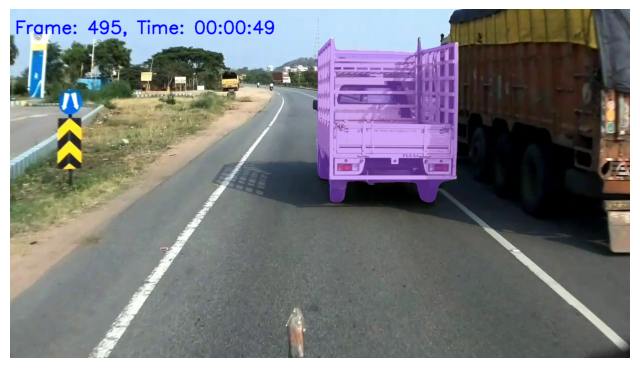

In [ ]:
masks = masks_to_bool(masks)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

Pixel count of masked area: 484496
Mask shape: (1, 720, 1280)


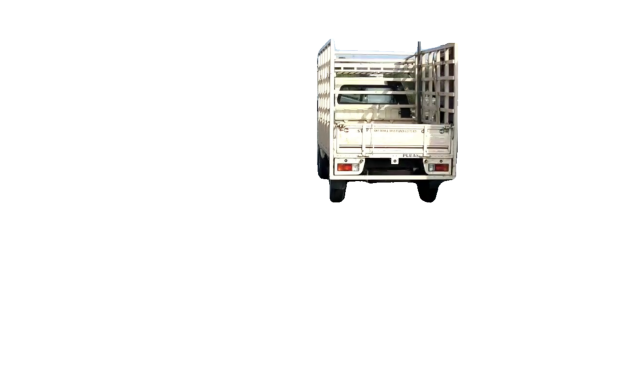

In [ ]:
# Display pixel count
print(f"Pixel count of masked area: {masked_pixels}")

import cv2
import matplotlib.pyplot as plt
import numpy as np

# Check the shape of the masks array
print(f"Mask shape: {masks.shape}")

# Extract the masked part of the image
original_image = cv2.imread(IMAGE_PATH)
height, width = original_image.shape[:2]
masked_image = np.zeros_like(original_image)

# Ensure the mask is in the correct shape
if len(masks.shape) == 3 and masks.shape[0] == 1:
    masks = masks[0]  # Remove the first dimension if it's a singleton

# Resize the mask to match the original image dimensions if necessary
if masks.shape[0] != height or masks.shape[1] != width:
    masks_resized = cv2.resize(masks.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST).astype(bool)
else:
    masks_resized = masks

# Apply the mask to the original image
for i in range(3):  # Apply mask to each channel (R, G, B)
    masked_image[:, :, i] = np.where(masks_resized, original_image[:, :, i], 255)

# Plot the masked image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
